# Gamma ray bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [1]:
import requests
from sklearn import datasets
from sklearn import mixture
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import colors
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn

Download data from the source: 

In [2]:
# Download file
#r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
#with open("Summary_table.txt", 'wb') as f:
    #f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
data  # check what 'data' variable contains

array([['GRB230514A*', 'GRB230513A*', 'GRB230512A*', ..., 'GRB910424A*',
        'GRB910423A*', 'GRB910421A*'],
       ['GRB230514996', 'GRB230513929', 'GRB230512269', ..., 'None',
        'None', 'None'],
       ['23:54:16.152', '22:17:18.149', '6:27:45.413', ...,
        '19:43:25.064', '19:51:15.804', '9:14:03.800'],
       ...,
       ['5.8880', '4.8000', '2.6240', ..., '3.1360', '208.5760',
        '5.6960'],
       ['True', 'True', 'True', ..., 'False', 'False', 'False'],
       ['60078.99602028', '60077.92868228', '60076.26927561', ...,
        '48370.82181787', '48369.82726625', '48367.38476620']],
      dtype='<U14')

Create the arrays of variable I decided to analyze: 

In [4]:
T90_s = np.array(data[6],dtype=float)
z_s = np.array(data[11],dtype=float)
fluence_s = np.array(data[9],dtype=float)

In [5]:
# mask unphysical values
z_corr = z_s[z_s>0]
fluence_corr = fluence_s[fluence_s>0]
T90_corr = T90_s[T90_s>0]

# 1-D distributions

I here report the 1-dimensional distribution of the three variables I decided to study. I will then apply some statistics to see if I can catch some of the features of these curves, and link them to the physics of gamma ray bursts (which I know little about, but will compensate with the help of Google). 

In [6]:
# using Friedmann Diaconis thumb rule: 

opt_bins_z = 2 * (np.quantile(z_corr, 0.75) - np.quantile(z_corr, 0.25)) / len(z_corr)**(1/3)
opt_bins_t90 = 2 * (np.quantile(T90_corr, 0.75) - np.quantile(T90_corr, 0.25)) / len(T90_corr)**(1/3)
opt_bins_f = 2 * (np.quantile(fluence_corr, 0.75) - np.quantile(fluence_corr, 0.25)) / len(fluence_corr)**(1/3)

print("optimal bins length found:")
print(opt_bins_z, opt_bins_t90, opt_bins_f)

optimal bins length found:
0.4184370957525599 4.679046318645819 4.6909111130461595e-07


Since order or $10^{-7}$ for the bins would crash my computer, I am not using this estimate for the fluence binning, probably it will be a huge problem in the visualization.

In [7]:
bins_z = np.append(np.arange(start=z_corr.min(), stop=z_corr.max(), step=opt_bins_z) , z_corr.max())
bins_t90 = np.append(np.arange(start=T90_corr.min(), stop=T90_corr.max(), step=opt_bins_t90) , T90_corr.max())
bins_f = 30

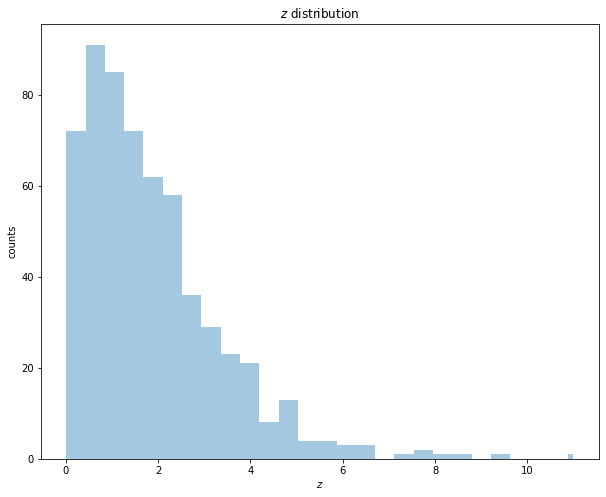

In [8]:
# Redshift

plt.figure(figsize=(10,8))
plt.hist(z_corr, bins=bins_z, alpha=0.4)
plt.xlabel(r"$z$")
plt.ylabel(r'counts')
plt.title('$z$ distribution');

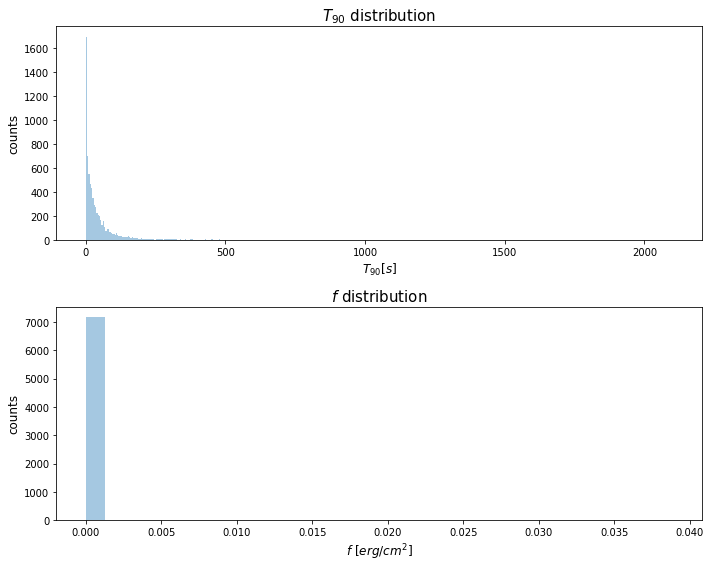

In [9]:
# T90 (duration) and fluence

fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].hist(T90_corr, bins=bins_t90, alpha=0.4)
ax[0].set_xlabel(r"$T_{90} [s]$", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title('$T_{90}$ distribution', fontsize=15)

ax[1].hist(fluence_corr, bins=bins_f, alpha=0.4)
ax[1].set_xlabel(r"$f$ [$erg/cm^2$]", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title('$f$ distribution', fontsize=15)

fig.tight_layout();

It is difficult to extrapolate something out of these plots (the second one especially), due to the scaling. I will try to switch to log scale: 

In [10]:
# same thumb rule:

opt_bins_t90_log = 2 * (np.quantile(np.log(T90_corr), 0.75) - np.quantile(np.log(T90_corr), 0.25)) / len(T90_corr)**(1/3)
opt_bins_f_log = 2 * (np.quantile(np.log(fluence_corr), 0.75) - np.quantile(np.log(fluence_corr), 0.25)) / len(fluence_corr)**(1/3)

print("optimal bins length found:")
print(opt_bins_t90_log, opt_bins_f_log)

optimal bins length found:
0.2360665126735706 0.23660708911508355


In [11]:
bins_f_log = np.append(np.arange(start=np.log(fluence_corr).min(), stop=np.log(fluence_corr).max(), step=opt_bins_f_log) , np.log(fluence_corr).max())
bins_t90_log = np.append(np.arange(start=np.log(T90_corr).min(), stop=np.log(T90_corr).max(), step=opt_bins_t90_log) , np.log(T90_corr).max())

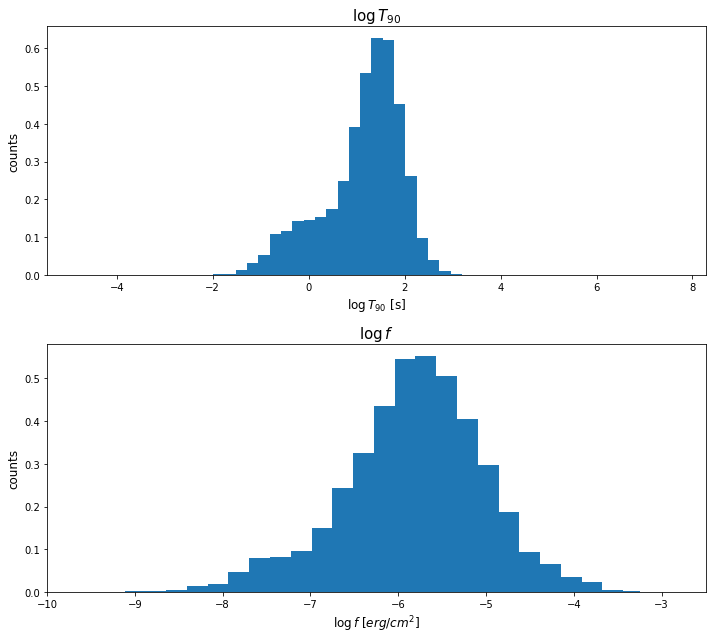

In [12]:
fig, ax = plt.subplots(2, figsize=(10,9))

ax[0].hist(np.log10(T90_corr), bins=bins_t90_log, density=True)
ax[0].set_xlabel(r"$\log{T_{90}}$ [s]", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title(r"$\log{T_{90}}$", fontsize=15)

ax[1].hist(np.log10(fluence_corr), bins=bins_f_log, density=True)
ax[1].set_xlabel(r"$\log{f}$ [$erg/cm^2$]", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title(r"$\log{f}$", fontsize=15)
ax[1].set_xlim(-10, -2.5)

fig.tight_layout();

Much better! 

## KDE 

I now carry out the kernel density estimation we saw some lectures ago. 
Each data point is represented not as a delta function, but rather as a distribution. Those individual distributions are summed up to produce the PDF.  

In [13]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

## $z$

I am quite sure there is no bimodality in z, however, I am going to see by the KDE if I missed something.

In [14]:
bwrange = np.linspace(0.01, 0.5, 20) # Test 10 bandwidths from 0.1 to 1.0
print(bwrange)

K = 5 # Do 5-fold cross validation

X_z = z_corr[:, None]

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(X_z) #Fit the histogram data 

h_opt = (grid.best_params_['bandwidth'])
    
print(h_opt)

[0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
0.3968421052631579


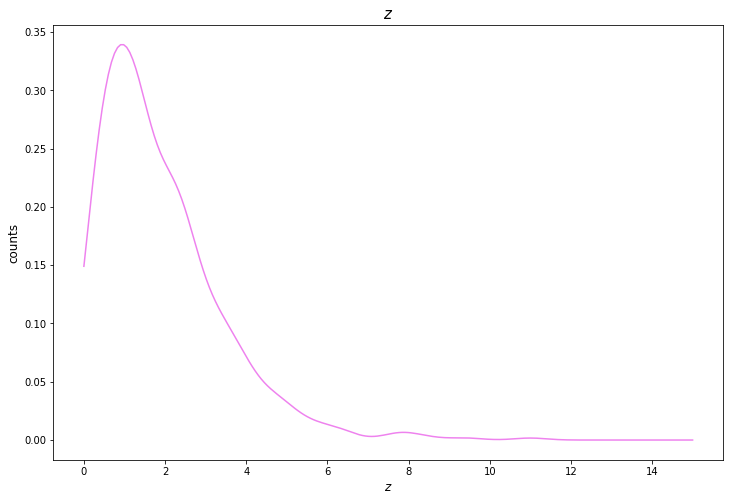

In [15]:
plt.figure(figsize=(12,8))
xgrid =np.linspace(0, 15, 200)
pdf = kde_sklearn(z_corr, bandwidth=h_opt)
plt.plot(xgrid, pdf, c='violet')
plt.xlabel(r"$z$", fontsize=12)
plt.ylabel(r'counts', fontsize=12)
plt.title(r"$z$", fontsize=15);

Here we see how the distribution is peaked at $z \sim 1$ (by eye..).

In [16]:
print(xgrid[np.argmax(pdf)])

0.9798994974874371


### Conclusion: 
There is no bimodality in $z$.

## $\log{T_{90}}$ and $\log{f}$

In [17]:
bwrange = np.linspace(0.01, 0.5, 20) # Test 10 bandwidths from 0.1 to 1.0
print(bwrange)

K = 5 # Do 5-fold cross validation

X_f = np.log10(fluence_corr[:, None])
X_t = np.log10(T90_corr[:, None])

h_opt = []

for X in [X_f, X_t]:

    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
    grid.fit(X) #Fit the histogram data 

    h_opt.append(grid.best_params_['bandwidth'])
    
print(h_opt)

[0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
[0.29368421052631577, 0.1131578947368421]


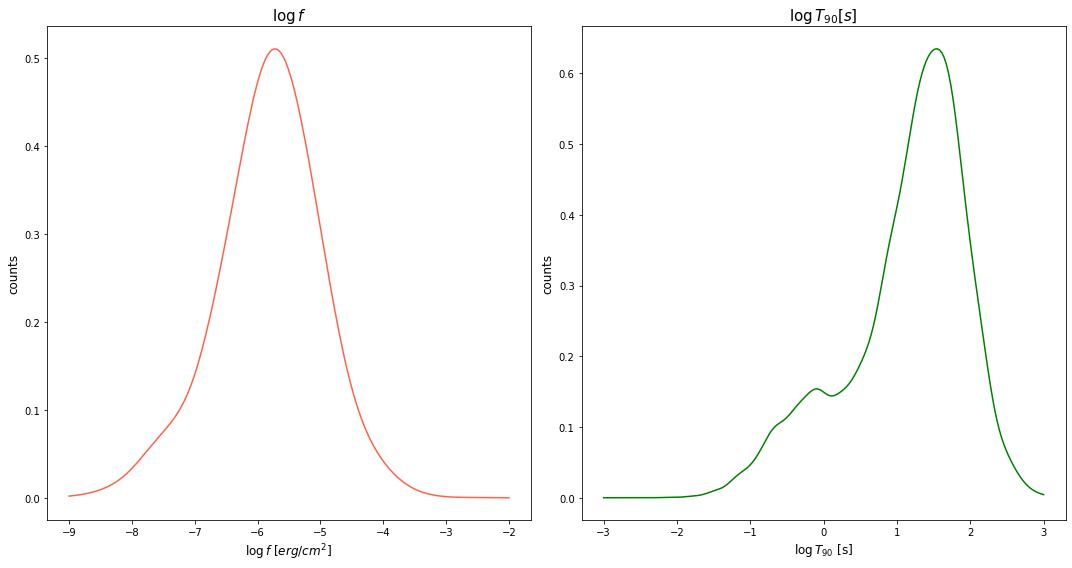

In [18]:
pdf = []

fig, ax = plt.subplots(1, 2, figsize=(15,8))

xgrid_f =np.linspace(-9, -2, 200)
xgrid_t =np.linspace(-3, 3, 200)

for xgrid, i, x in zip([xgrid_f, xgrid_t], [0, 1], [np.log10(fluence_corr), np.log10(T90_corr)]): 

    pdf.append(kde_sklearn(x, bandwidth=h_opt[i]))

ax[0].plot(xgrid_f, pdf[0], c='tomato')
ax[1].plot(xgrid_t, pdf[1], c='green')

ax[0].set_xlabel(r"$\log{f}$ [$erg/cm^2$]", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title(r"$\log{f}$", fontsize=15)

ax[1].set_xlabel(r"$\log{T_{90}}$ [s]", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title(r"$\log{T_{90}} [s]$", fontsize=15)

fig.tight_layout();

### Conclusions: 

I see from these plots that there seem to be one type of bursts in terms of the fluence, while there are perhaps two distinct populations of bursts in terms of the duration. I will try to inverstigate the latter hypothesis using the clustering methods we saw in our lecture.  

## Clustering

The clustering techniques are useful to investigate whether there are different groups of data that have the same features. I will use them to first see if we can split the gamma ray bursts in some classes based on the different types of data we acquired. 

### $\log{T_{90}}$ 

From the KDE it seems that only $\log{T_{90}}$ has an evident bimodality, hence my choice to investigate only its shape. 
I will try to first set $n_{cl} = 2$, just to see if something sensed comes out.

In [19]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)
k_means.fit(X_t)

Y_t = k_means.predict(X_t)

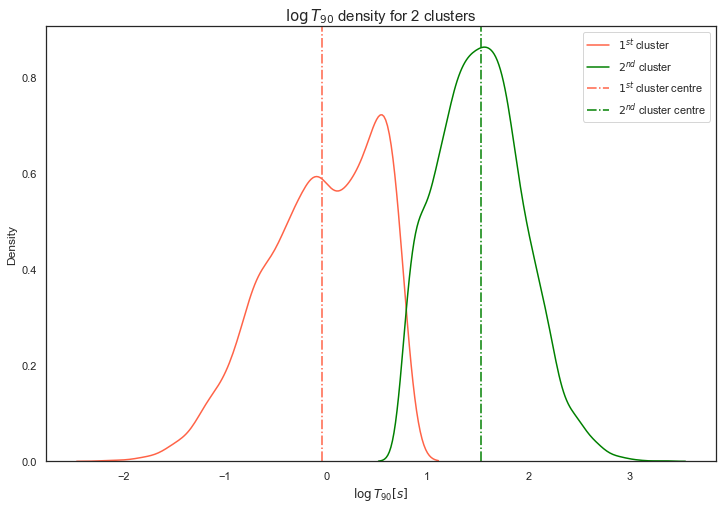

In [20]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

seaborn.kdeplot(np.log10(T90_corr[Y_t==0]), c='tomato', label=r'$1^{st}$ cluster')
seaborn.kdeplot(np.log10(T90_corr[Y_t==1]), c='green', label=r'$2^{nd}$ cluster')
plt.axvline(k_means.cluster_centers_[0], linestyle='-.', c='tomato', label='$1^{st}$ cluster centre')
plt.axvline(k_means.cluster_centers_[1], linestyle='-.', c='green', label='$2^{nd}$ cluster centre')
plt.xlabel(r"$\log{T_{90}} [s]$")
plt.title(f"$\log{{T_{{90}}}}$ density for {n_clusters} clusters", fontsize=15)

plt.legend();

Now I want to see if my first guess can be seen as the optimal choice for the clustering method. I will use the Meanshift algorithm.

In [21]:
#first estimate the optimal bandwidth
bandwidth = estimate_bandwidth(X_t, quantile=0.2) 

print("optimal bandwidth:", bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit(X_t)

Y_t_ms = ms.predict(X_t)

optimal bandwidth: 0.36890317156764857


In [22]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 0
total number of estimated clusters : 2


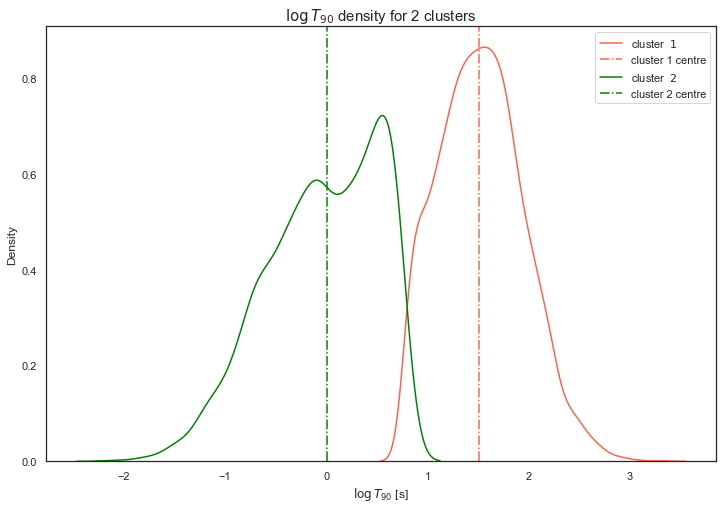

In [23]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

colors = ['tomato', 'green']

for i in range(0, n_clusters): 

    seaborn.kdeplot(np.log10(T90_corr[Y_t_ms == i]), label=f'cluster  ${i + 1}$', c=colors[i])
    
    plt.axvline(ms.cluster_centers_[i], linestyle='-.', c=colors[i], label=f'cluster {i+1} centre')

plt.xlabel(r"$\log{T_{90}}$ [s]")
plt.title(f"$\log{{T_{{90}}}}$ density for {n_clusters} clusters", fontsize=15)

plt.legend();

In [24]:
print("KMeans centres:", k_means.cluster_centers_[0], k_means.cluster_centers_[1])
print("MS centre:", ms.cluster_centers_[0], ms.cluster_centers_[1])

KMeans centres: [-0.0413919] [1.52697445]
MS centre: [1.50754253] [0.0104042]


From this initial analysis I learned two main things: 
    
- 1) The variable that shows the multi-modality more evidently is the $T_{90}$ one, while the other two seem to have just one mode;

- 2) The two clustering methods I used returned quite the same results, so they can be used indifferently for the 1-D analysis.

# 2-D distributions

In this section I am interested to test whether I could have studied the bimodality in the two-dimensional space. I decided to plot $\log{f}$ vs $\log{T_{90}}$, but I could have easily chosen also $z$ vs $\log{T_{90}}$ (just because this way I had a log-log plot).

In [25]:
# create mask for non-physical values

mask = np.logical_and(T90_s>0, fluence_s>0)
fluence_corr = fluence_s[mask]
T90_corr = T90_s[mask]

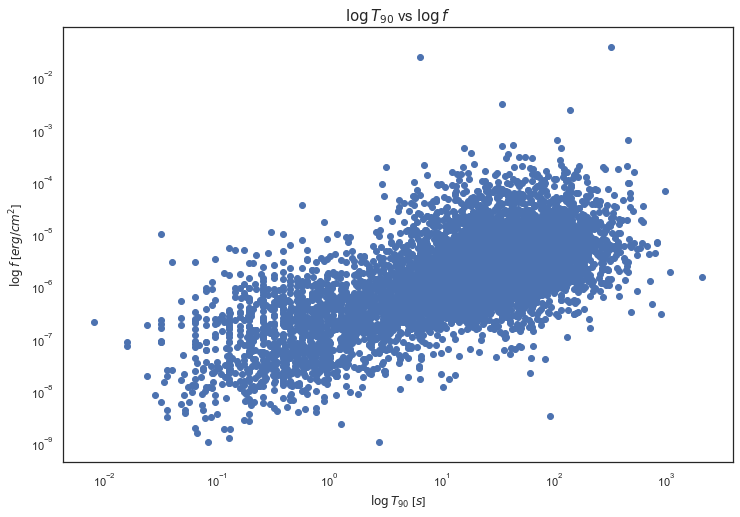

In [26]:
#plt.figure(figsize=(10,8))
plt.loglog(T90_corr, fluence_corr, 'o')
plt.xlabel(r"$\log{T_{90}}$ [$s$]", fontsize=12)
plt.ylabel("$\log{f}$ [$erg/cm^2$]", fontsize=12)
plt.title(r'$\log{T_{90}}$ vs $\log{f}$', fontsize=15); 

To prepare for the analysis I regroup the valid data into a matrix:

In [27]:
matrix_val = np.array((np.log10(T90_corr), np.log10(fluence_corr)))
f_vs_t90 = matrix_val.transpose()

## Clustering

I first try with the KMeans method: by eye I would initially say we see two groups of bursts, depending on the value of $T_{90}$.  

In [28]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)

k_means.fit(f_vs_t90)

KMeans(n_clusters=2)

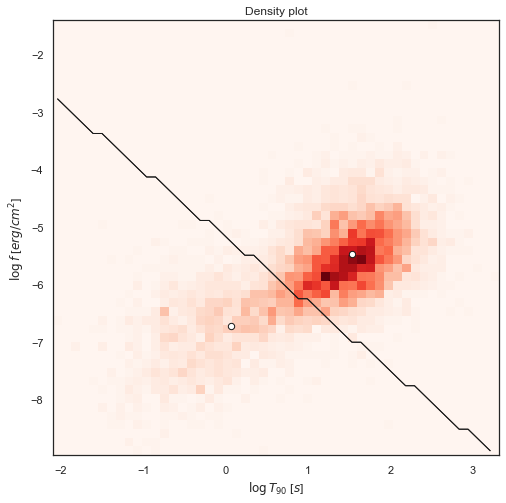

In [29]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:,0], f_vs_t90[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = k_means.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = k_means.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = k_means.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$\log{T_{90}}$ [$s$]")
ax.set_ylabel("$\log{f}$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

It seems to properly identify the two centers. Let's see if the Meanshift algorithm works out the same solution or not: 

In [30]:
bandwidth = estimate_bandwidth(f_vs_t90) 

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit((f_vs_t90))

MeanShift(bandwidth=0.9193541505407515, bin_seeding=True, cluster_all=False)

In [31]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 1
total number of estimated clusters : 3


In [32]:
# to make the plot
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

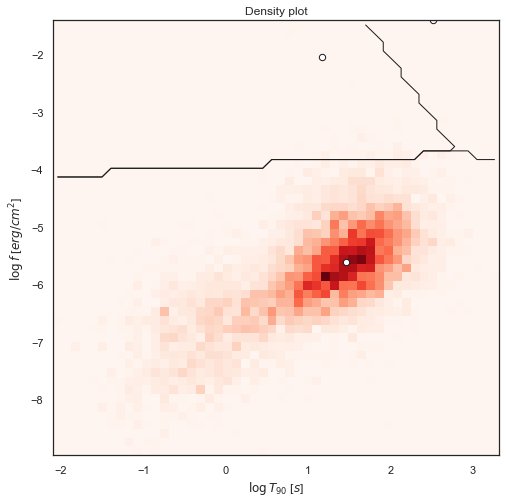

In [33]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:, 0], f_vs_t90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = ms.cluster_centers_
for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$\log{T_{90}}$ [$s$]")
ax.set_ylabel("$\log{f}$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

Here, we see how the behaviour is different. Apparently, the algorithm sees only one center in the bulge, and associates it with one of the three identified clusters' centres. I will try to change the following parameters to see if anything improves: 

- $\textit{bandwidth}$; 
- $\texttt{cluster_all}$ option;

In [34]:
ms = MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False) 

ms.fit((f_vs_t90))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

In [35]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 6
number of estimated singletons : 6
total number of estimated clusters : 12


In [36]:
# to make the plot
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

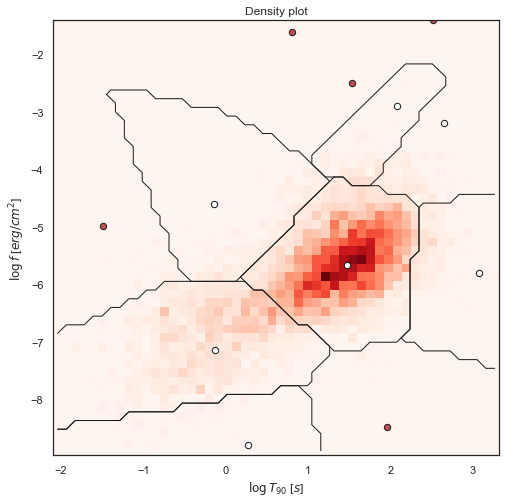

In [37]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:, 0], f_vs_t90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = ms.cluster_centers_

for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$\log{T_{90}}$ [$s$]")
ax.set_ylabel("$\log{f}$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

The red centroids are the $\textbf{singletons}$. I hoped to see that mostly the algorithm was able to find two "real" centroids and the others were just resulting from the outliers effect on the gradient. I instead proved that the algorithm fails in this case to find a suitable number of clusters, returning at least $6$ viable instead of $2$ or $3$. 

Changing the $\textit{bandwidth}$ helped to get the two expected centroids in about the about the same position as the KMeans method, but also added up new centroids to the clustering results. Changing the $\texttt{cluster_all}$ option just reduced the amount of singletons, but didn't change anything in the outcome of the algorithm. 

The last method I will try is the 2-D Gaussian Mixture (a classification method), with two components:

In [38]:
ggm = mixture.GaussianMixture(n_components=2, random_state=0)

ggm.fit(f_vs_t90)

c = mixture.GaussianMixture(n_components=2, random_state=0).fit_predict(f_vs_t90)

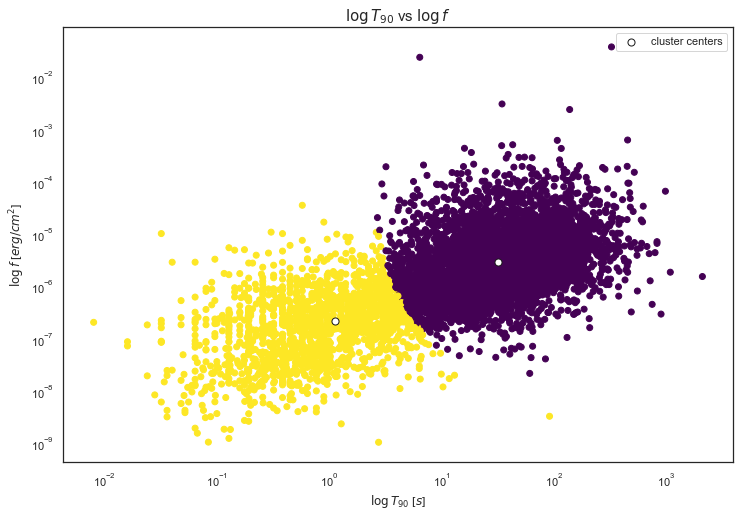

In [39]:
plt.scatter(T90_corr, fluence_corr, c=c, cmap='viridis')
plt.scatter(10**ggm.means_[0, 0], 10**ggm.means_[0, 1], c='w', edgecolors='k', s=50, label='cluster centers')
plt.scatter(10**ggm.means_[1, 0], 10**ggm.means_[1, 1], c='w', edgecolors='k', s=50)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\log{T_{90}}$ [$s$]", fontsize=12)
plt.ylabel("$\log{f}$ [$erg/cm^2$]", fontsize=12)
plt.title(r'$\log{T_{90}}$ vs $\log{f}$', fontsize=15)
plt.legend();

Up until now, this is what I found. 

$\textbf{Physics related}$: there are two semi-distinct populations of bursts, depending on the duration only. Apparently, the other distributions appear to be one-modal. From the internet I recovered that indeed gamma ray bursts can be divided into two categories: 

- long GRB: average duration of about 30 s;
- short GRB: average duration of 0.3 s;

The threshold is usually set to $\sim 2$ s.


$\textbf{Algorithms related}$: among the many algorithms I used, the Meanshift proved to be the most problematic when it came to outliers in data. In fact it would substantially fail to identify the clusters correctly, finding a lot more. It is probably due to its structure, where very far points would inevitably weigh in the gradient calculation. 

## What about the errors?

I did not mention anything concerning the errors in data, that were still present in the dataset: I am now going to check whether that affects my analysis significantly or not.

In [40]:
# reload data since it doesn't take long, and avoids errors in the notebook

T90_s = np.array(data[6],dtype=float)
z_s = np.array(data[11],dtype=float)
fluence_s = np.array(data[9],dtype=float)
T90_s_err = np.array(data[7],dtype=float)
fluence_s_err = np.array(data[10],dtype=float)

In [41]:
mask = np.logical_and(T90_s>0, fluence_s>0)

fluence_err_corr = fluence_s_err[mask]
T90_err_corr = T90_s_err[mask]

T90_corr = T90_s[mask]
fluence_corr = fluence_s[mask]

Now I am plotting the relative error (as we saw in the lecture): 

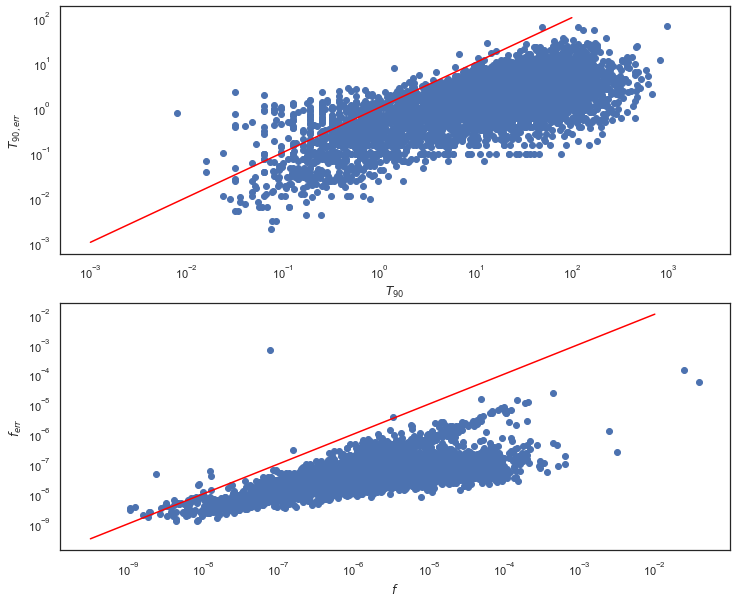

In [42]:
xgrid_t = np.logspace(-3, 2, 4) 
xgrid_f = np.logspace(-9.5, -2, 4)

fig, ax = plt.subplots(2, figsize=(12, 10))

ax[0].scatter(T90_corr, T90_err_corr)
ax[0].plot(xgrid_t, xgrid_t, '-', c='red')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$T_{90}$')
ax[0].set_ylabel('$T_{90, err}$')


ax[1].scatter(fluence_corr, fluence_err_corr)  # in both cases check if the error is of the order of the measurement
ax[1].plot(xgrid_f, xgrid_f, '-', c='red')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel('$f_{err}$'); 

This should be telling me that it's okay not to use the error in my analysis, since it's $\textit{relatively}$ very small for all quantities. 

## PCA

The last thing I am asking myself is whether 1 is enough dimensionality to describe my dataset. I am adding the PCA from the next lecture. 

In [43]:
fluence_err_corr = fluence_s_err[mask]
T90_err_corr = T90_s_err[mask]

T90_corr = T90_s[mask]
fluence_corr = fluence_s[mask]
z_corr = z_s[mask]

In [59]:
dataset_comp = np.array([z_corr, T90_corr, fluence_corr, T90_err_corr, fluence_err_corr]).T

In [60]:
dataset_comp.shape  # check it has the right shape

(6995, 5)

In [61]:
evals = []

for num_feats in np.arange(1,6, dtype = int):
    
    pca = PCA(n_components=num_feats, whiten=True) # having the whitening done doesn't change much in this case
    pca.fit(dataset_comp)
    
evals.append(pca.explained_variance_ratio_)
    
    
    #if (sum(pca.explained_variance_ratio_) > 0.8):
        #break
#print("{:d} features are needed to explain 80% of the total variance".format(num_feats))  # I chose to keep the variance up to 80%

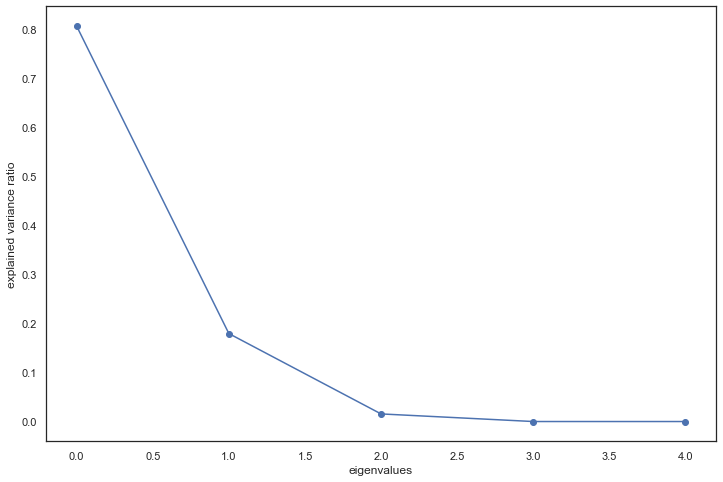

In [62]:
n_components = 5

plt.scatter(np.arange(n_components), evals)
plt.plot(np.arange(n_components), evals[0])

plt.xlabel('eigenvalues')
plt.ylabel('explained variance ratio');

As we can see from this plot, the first component explains well 80% of the variance ratio over the total variance of the dataset. If I really wanted to be extremely precise, then I would probably keep 3 components instead of one (where gradient becomes zero). 